In [1]:
# USE THIS NOTEBOOK FOR ANALYSIS AND EXPERIMENTATION

In [2]:
from pyspark.sql import SparkSession
import matplotlib.pyplot as plt

spark = SparkSession.builder \
    .appName("Data Exploration") \
    .getOrCreate()

df = spark.read.csv('converted.csv', header=True, inferSchema=True)

print(f"Rows: {df.count()} | Columns: {len(df.columns)} | Data points: {df.count() * len(df.columns)}")
df.printSchema()

Rows: 97429 | Columns: 43 | Data points: 4189447
root
 |-- AppID: string (nullable = true)
 |-- index: string (nullable = true)
 |-- Name: string (nullable = true)
 |-- Release date: string (nullable = true)
 |-- Required age: string (nullable = true)
 |-- Price: string (nullable = true)
 |-- DLC count: string (nullable = true)
 |-- Detailed description: string (nullable = true)
 |-- About the game: string (nullable = true)
 |-- Short description: string (nullable = true)
 |-- Reviews: string (nullable = true)
 |-- Header image: string (nullable = true)
 |-- Website: string (nullable = true)
 |-- Support url: string (nullable = true)
 |-- Support email: string (nullable = true)
 |-- Windows: string (nullable = true)
 |-- Mac: string (nullable = true)
 |-- Linux: string (nullable = true)
 |-- Metacritic score: string (nullable = true)
 |-- Metacritic url: string (nullable = true)
 |-- Achievements: string (nullable = true)
 |-- Recommendations: string (nullable = true)
 |-- Notes: strin

In [3]:
df.createOrReplaceTempView("Game_Release_Date_P")
release_dates = spark.sql("SELECT `Name`,`Release date`, `Tags`, `Genres`, `Categories` FROM Game_Release_Date_P")
release_dates.show()

+--------------------+------------+--------------------+--------------------+--------------------+
|                Name|Release date|                Tags|              Genres|          Categories|
+--------------------+------------+--------------------+--------------------+--------------------+
|    Galactic Bowling|Oct 21, 2008|Indie,Casual,Spor...| Casual,Indie,Sports|Single-player,Mul...|
|        Train Bandit|Oct 12, 2017|Indie,Action,Pixe...|        Action,Indie|Single-player,Ste...|
|        Jolt Project|Nov 17, 2021|                null|Action,Adventure,...|       Single-player|
|            Henosis™|Jul 23, 2020|2D Platformer,Atm...|Adventure,Casual,...|Single-player,Ful...|
|Two Weeks in Pain...| Feb 3, 2020|Indie,Adventure,N...|     Adventure,Indie|Single-player,Ste...|
|      Wartune Reborn|Feb 26, 2021|Turn-Based Combat...|Adventure,Casual,...|Single-player,Mul...|
|           TD Worlds| Jan 9, 2022|Tower Defense,Rog...|      Indie,Strategy|Single-player,Ste...|
|Legend of

In [4]:
# PREPROCESSING AND CLEANING

In [5]:
# Dropping irrelevant columns. These columns contain URLs which we do not require for our analysis. 
columns_to_drop = [
    "Header image", "Website", "Support url", "Support email",
    "Metacritic url", "Screenshots", "Movies", "Score rank"
]

df = df.drop(*columns_to_drop)

print(f"Rows: {df.count()} | Columns: {len(df.columns)} | Data points: {df.count() * len(df.columns)}")

Rows: 97429 | Columns: 35 | Data points: 3410015


In [6]:
from pyspark.sql.functions import col, expr

# Identify non-numeric AppIDs using expr
non_numeric_app_ids = df.filter(~expr("AppID RLIKE '^[0-9]+$'"))
non_numeric_count = non_numeric_app_ids.count()
total_rows = df.count()
print(f"Total rows: {total_rows}")
print(f"Number of non-numeric AppIDs: {non_numeric_count}")

# Show examples of non-numeric AppIDs
print("Non-numeric AppIDs:")
non_numeric_app_ids.select("AppID", "Name", "Price", "Release date").show(10, truncate=False)

# Drop non-numeric AppIDs
df = df.filter(expr("AppID RLIKE '^[0-9]+$'"))
print(f"Row count after dropping non-numeric AppIDs: {df.count()}")

Total rows: 97429
Number of non-numeric AppIDs: 19
Non-numeric AppIDs:
+---------------+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+----------------------------------------------+-------------------------------+
|AppID          |Name                                                                                                                                                                                                          |Price                                         |Release date                   |
+---------------+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+----------------------------------------------+-------------------------------+
|French         |

In [7]:
# Check for duplicate AppIDs
app_id_duplicates = df.groupBy("AppID").count().filter(col("count") > 1)
duplicate_count = app_id_duplicates.count()
print(f"Number of duplicate AppIDs: {duplicate_count}")

Number of duplicate AppIDs: 0


In [8]:
from pyspark.sql.functions import col, expr
from pyspark.sql.types import DoubleType
import matplotlib.pyplot as plt
import pandas as pd

#Check for non-numeric strings in Price
non_numeric_prices = df.filter(~expr("Price RLIKE '^[0-9]+\\.?[0-9]*$'") & col("Price").isNotNull())
non_numeric_count = non_numeric_prices.count()
total_rows = df.count()
print(f"Total rows: {total_rows}")
print(f"Number of non-numeric Price values: {non_numeric_count}")

# Remove rows with non-numeric Prices
df = df.filter(expr("Price RLIKE '^[0-9]+\\.?[0-9]*$'") | col("Price").isNull())
print(f"Row count after removing non-numeric Prices: {df.count()}")

# Convert Price to DoubleType
df = df.withColumn("Price", col("Price").cast(DoubleType()))

# Verify conversion
df.printSchema()

Total rows: 97410
Number of non-numeric Price values: 2
Row count after removing non-numeric Prices: 97408
root
 |-- AppID: string (nullable = true)
 |-- index: string (nullable = true)
 |-- Name: string (nullable = true)
 |-- Release date: string (nullable = true)
 |-- Required age: string (nullable = true)
 |-- Price: double (nullable = true)
 |-- DLC count: string (nullable = true)
 |-- Detailed description: string (nullable = true)
 |-- About the game: string (nullable = true)
 |-- Short description: string (nullable = true)
 |-- Reviews: string (nullable = true)
 |-- Windows: string (nullable = true)
 |-- Mac: string (nullable = true)
 |-- Linux: string (nullable = true)
 |-- Metacritic score: string (nullable = true)
 |-- Achievements: string (nullable = true)
 |-- Recommendations: string (nullable = true)
 |-- Notes: string (nullable = true)
 |-- Supported languages: string (nullable = true)
 |-- Full audio languages: string (nullable = true)
 |-- Packages: string (nullable = tr

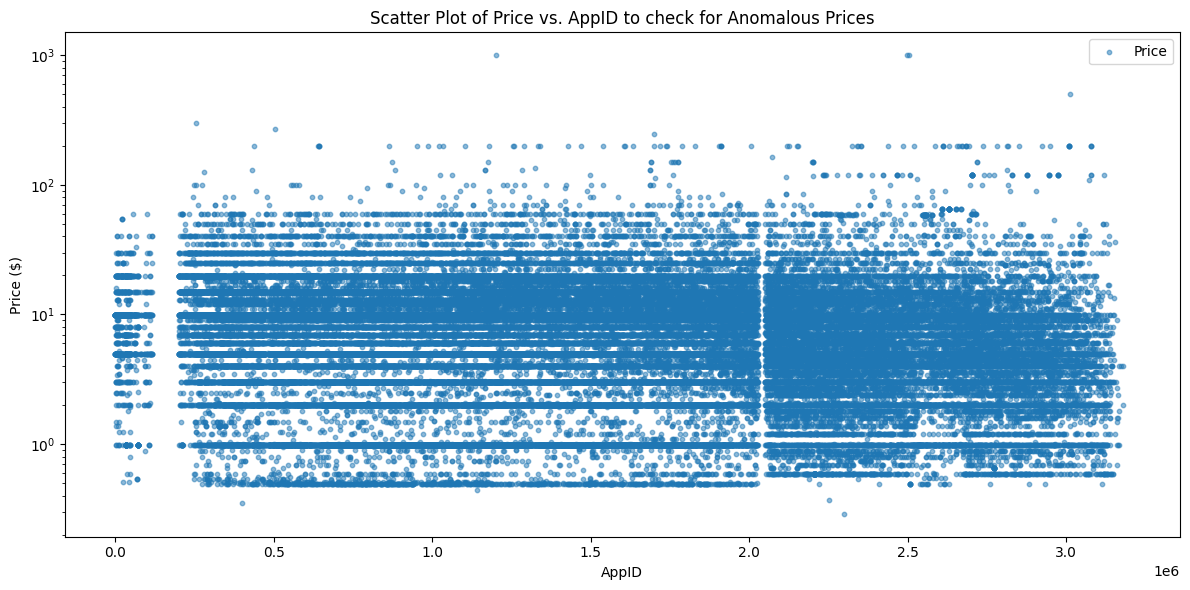

Final Price summary:
+-------+------------------+
|summary|             Price|
+-------+------------------+
|  count|             97408|
|   mean| 7.085822417049952|
| stddev|12.387895823589028|
|    min|               0.0|
|    max|            999.98|
+-------+------------------+



In [9]:
# Scatter plot of AppID vs Price to check for absurdly high values. 
df_sample = df.select("AppID", "Price").toPandas()
df_sample["AppID"] = pd.to_numeric(df_sample["AppID"], errors="coerce")

plt.figure(figsize=(12, 6))
plt.scatter(df_sample["AppID"], df_sample["Price"], alpha=0.5, s=10, label="Price")
plt.title("Scatter Plot of Price vs. AppID to check for Anomalous Prices")
plt.xlabel("AppID")
plt.ylabel("Price ($)")
plt.yscale("log")
plt.legend()
plt.tight_layout()
plt.show()

# Final verification
print("Final Price summary:")
df.describe("Price").show()

In [10]:
from pyspark.sql.functions import to_date, col, concat, lit, when

# Initial conversion with legacy parser
spark.conf.set("spark.sql.legacy.timeParserPolicy", "LEGACY")
df = df.withColumn("Release_date_cleaned", to_date(col("Release date"), "MMM dd, yyyy"))

# Check for conversion failures
conversion_failures = df.filter(col("Release date").isNotNull() & col("Release_date_cleaned").isNull()).count()
print(f"Number of Release date conversion failures: {conversion_failures}")

# Show the failures
if conversion_failures > 0:
    print("Failed Release dates:")
    df.filter(col("Release date").isNotNull() & col("Release_date_cleaned").isNull()).select("Release date").show(20, truncate=False)

# Process failures by adding "01" as the day
df = df.withColumn("Release_date_cleaned", 
    when(col("Release date").isNotNull() & col("Release_date_cleaned").isNull(), 
         to_date(concat(col("Release date"), lit(" 01")), "MMM yyyy dd"))  # Add "01" and parse
    .otherwise(col("Release_date_cleaned"))  # Keep successful conversions
)

# Recheck for any remaining failures
remaining_failures = df.filter(col("Release date").isNotNull() & col("Release_date_cleaned").isNull()).count()
print(f"Number of remaining Release date conversion failures: {remaining_failures}")

# Show remaining failures
if remaining_failures > 0:
    print("Remaining problematic Release dates:")
    df.filter(col("Release date").isNotNull() & col("Release_date_cleaned").isNull()).select("Release date").show(10, truncate=False)

# Drop rows with remaining anomalous dates
if remaining_failures > 0:
    print(f"Dropping {remaining_failures} rows with anomalous Release dates...")
    df = df.filter(~(col("Release date").isNotNull() & col("Release_date_cleaned").isNull()))
    print(f"Row count after dropping anomalous dates: {df.count()}")

# Show sample of original vs cleaned
print("Sample of original vs cleaned Release date:")
df.select("Release date", "Release_date_cleaned").show(10, truncate=False)

# Replace original column
df = df.drop("Release date").withColumnRenamed("Release_date_cleaned", "Release date")

Number of Release date conversion failures: 134
Failed Release dates:
+------------+
|Release date|
+------------+
|May 2020    |
|Aug 2020    |
|Mar 2017    |
|Dec 2012    |
|Jun 2021    |
|May 2020    |
|May 2021    |
|Jan 2019    |
|Aug 2014    |
|Nov 2014    |
|Jul 2018    |
|May 2018    |
|May 2015    |
|Aug 2016    |
|Apr 2010    |
|Jan 2022    |
|Jul 2017    |
|Mar 2010    |
|Aug 2017    |
|Aug 2020    |
+------------+
only showing top 20 rows

Number of remaining Release date conversion failures: 3
Remaining problematic Release dates:
+-------------------------------------------------------+
|Release date                                           |
+-------------------------------------------------------+
| Please!"" Collection"                                 |
| So I Recruited Everyone I Know To Fight The Dark Lord"|
| sed non obligant.""』"                                |
+-------------------------------------------------------+

Dropping 3 rows with anomalous Release dates.

In [11]:
from pyspark.sql.functions import col, split, udf
from pyspark.sql.types import IntegerType, DoubleType, ArrayType, StringType

# Cast other numeric fields
numeric_columns = [
    "Required age", "DLC count", "Achievements", "Recommendations",
    "Positive", "Negative", "Metacritic score", 
    "Average playtime forever", "Average playtime two weeks",
    "Median playtime forever", "Median playtime two weeks",
    "Peak CCU", "User score"
]

for col_name in numeric_columns:
    df = df.withColumn(col_name, col(col_name).cast(DoubleType()))
    

In [12]:
# Split Tags and Genres into arrays
df = df.withColumn("Tags", split(col("Tags"), ","))
df = df.withColumn("Genres", split(col("Genres"), ","))
df = df.withColumn("Categories", split(col("Categories"), ","))

# Trim whitespace from each element
def trim_array(arr):
    if arr:
        return [x.strip() for x in arr]
    return []

trim_udf = udf(trim_array, ArrayType(StringType()))
df = df.withColumn("Tags", trim_udf(col("Tags")))
df = df.withColumn("Genres", trim_udf(col("Genres")))
df = df.withColumn("Categories", trim_udf(col("Categories")))



In [13]:
print(f"Rows: {df.count()} | Columns: {len(df.columns)} | Data points: {df.count() * len(df.columns)}")
df.printSchema()

Rows: 97405 | Columns: 35 | Data points: 3409175
root
 |-- AppID: string (nullable = true)
 |-- index: string (nullable = true)
 |-- Name: string (nullable = true)
 |-- Required age: double (nullable = true)
 |-- Price: double (nullable = true)
 |-- DLC count: double (nullable = true)
 |-- Detailed description: string (nullable = true)
 |-- About the game: string (nullable = true)
 |-- Short description: string (nullable = true)
 |-- Reviews: string (nullable = true)
 |-- Windows: string (nullable = true)
 |-- Mac: string (nullable = true)
 |-- Linux: string (nullable = true)
 |-- Metacritic score: double (nullable = true)
 |-- Achievements: double (nullable = true)
 |-- Recommendations: double (nullable = true)
 |-- Notes: string (nullable = true)
 |-- Supported languages: string (nullable = true)
 |-- Full audio languages: string (nullable = true)
 |-- Packages: string (nullable = true)
 |-- Developers: string (nullable = true)
 |-- Publishers: string (nullable = true)
 |-- Categorie

In [14]:
# Create temp view and run SQL query
df.createOrReplaceTempView("Game_Release_Date")
release_dates = spark.sql("SELECT `Name`,`Release date`, `Tags`, `Genres`, `Categories` FROM Game_Release_Date")
release_dates.show()

+--------------------+------------+--------------------+--------------------+--------------------+
|                Name|Release date|                Tags|              Genres|          Categories|
+--------------------+------------+--------------------+--------------------+--------------------+
|    Galactic Bowling|  2008-10-21|[Indie, Casual, S...|[Casual, Indie, S...|[Single-player, M...|
|        Train Bandit|  2017-10-12|[Indie, Action, P...|     [Action, Indie]|[Single-player, S...|
|        Jolt Project|  2021-11-17|                  []|[Action, Adventur...|     [Single-player]|
|            Henosis™|  2020-07-23|[2D Platformer, A...|[Adventure, Casua...|[Single-player, F...|
|Two Weeks in Pain...|  2020-02-03|[Indie, Adventure...|  [Adventure, Indie]|[Single-player, S...|
|      Wartune Reborn|  2021-02-26|[Turn-Based Comba...|[Adventure, Casua...|[Single-player, M...|
|           TD Worlds|  2022-01-09|[Tower Defense, R...|   [Indie, Strategy]|[Single-player, S...|
|Legend of

In [15]:
df.createOrReplaceTempView("Average_Game_Prices_Yearly")

avg_game_prices_yearly = spark.sql("""
    SELECT YEAR(`Release date`) AS year, AVG(`Price`) AS average_price
    FROM Average_Game_Prices_Yearly
    GROUP BY YEAR(`Release date`)
    ORDER BY year
""")

avg_game_prices_yearly.show()

+----+------------------+
|year|     average_price|
+----+------------------+
|1997|             4.995|
|1998|              9.99|
|1999|3.3266666666666667|
|2000|              7.49|
|2001|              9.99|
|2002|             14.99|
|2003|10.656666666666666|
|2004|              9.99|
|2005| 8.277142857142858|
|2006| 9.467536231884056|
|2007| 6.995963302752293|
|2008| 8.725000000000001|
|2009| 9.308921282798837|
|2010| 8.110841423948221|
|2011| 9.050874125874127|
|2012| 9.334733893557425|
|2013|10.858394308943096|
|2014|  8.71569155446757|
|2015|  7.50733382844412|
|2016| 6.988423913043426|
+----+------------------+
only showing top 20 rows



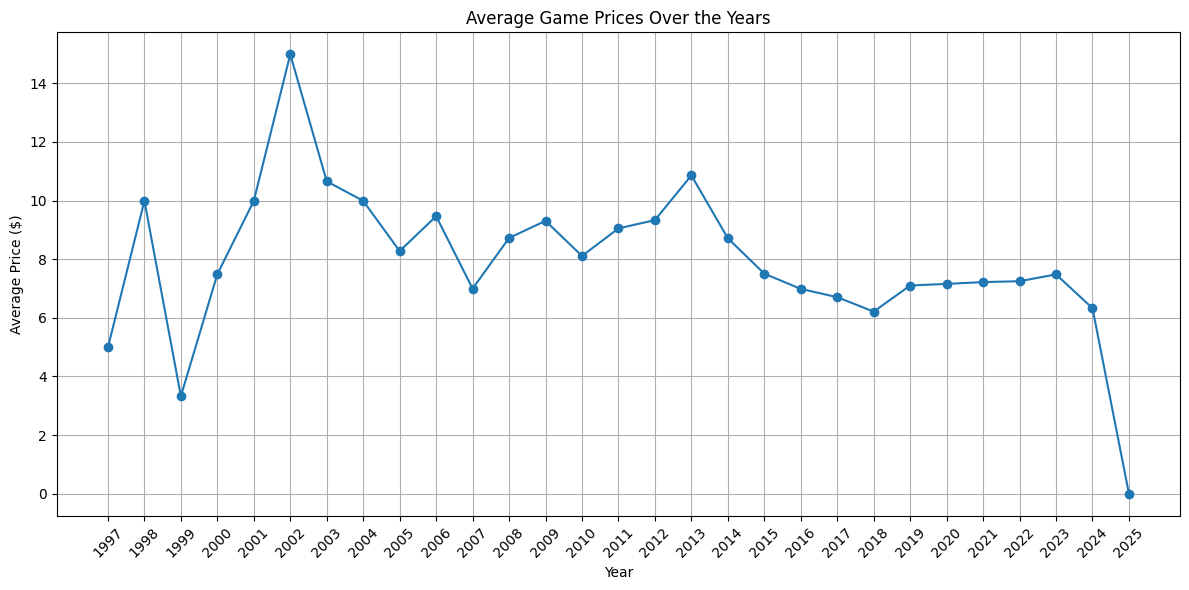

In [16]:
# Convert the result to a Pandas DataFrame for plotting
avg_game_prices_pd = avg_game_prices_yearly.toPandas()

# Plotting
plt.figure(figsize=(12, 6))
plt.plot(avg_game_prices_pd['year'], avg_game_prices_pd['average_price'], marker='o')
plt.title('Average Game Prices Over the Years')
plt.xlabel('Year')
plt.ylabel('Average Price ($)')
plt.xticks(avg_game_prices_pd['year'], rotation=45)
plt.grid()
plt.tight_layout()
plt.show()

In [17]:
from pyspark.sql.functions import col, count, mean, stddev, min, max
from tabulate import tabulate
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Define numeric columns
numeric_columns = [
    "Price", "Required age", "DLC count", "Achievements", "Recommendations",
    "Positive", "Negative", "Metacritic score", 
    "Average playtime forever", "Average playtime two weeks",
    "Median playtime forever", "Median playtime two weeks",
    "Peak CCU", "User score"
]

# Calculate summary statistics (Min, Max, Mean)
stats_df = df.select(numeric_columns).describe()

# Calculate Median (50% quantile) using approxQuantile
quantiles = {}
for col_name in numeric_columns:
    median = df.approxQuantile(col_name, [0.5], 0.05)[0]
    quantiles[col_name] = median

# Extract relevant stats from describe
stats_summary = stats_df.select(
    "summary",
    *[col(col_name).alias(col_name) for col_name in numeric_columns]
).filter(col("summary").isin("min", "max", "mean")).collect()

# Format the table
table_data = []
for col_name in numeric_columns:
    row = {"Feature": col_name}
    for stat_row in stats_summary:
        stat_type = stat_row["summary"]
        value = stat_row[col_name]
        row[stat_type.capitalize()] = float(value) if value else 0.0
    row["Median"] = quantiles[col_name]
    table_data.append(row)

# Print table for presentation
headers = ["Feature", "Min", "Max", "Mean", "Median"]
print(tabulate(
    [[row["Feature"], f"{row['Min']:.1f}", f"{row['Max']:.1f}", f"{row['Mean']:.1f}", f"{row['Median']:.1f}"] 
     for row in table_data],
    headers=headers,
    tablefmt="grid",
    floatfmt=".1f",
    stralign="left"
))


+----------------------------+-------+-----------+--------+----------+
| Feature                    |   Min |       Max |   Mean |   Median |
+============================+=======+===========+========+==========+
| Price                      |   0.0 |    1000.0 |    7.1 |      4.0 |
+----------------------------+-------+-----------+--------+----------+
| Required age               |   0.0 |      21.0 |    0.3 |      0.0 |
+----------------------------+-------+-----------+--------+----------+
| DLC count                  |   0.0 |    2366.0 |    0.5 |      0.0 |
+----------------------------+-------+-----------+--------+----------+
| Achievements               |   0.0 |    9821.0 |   18.6 |      0.0 |
+----------------------------+-------+-----------+--------+----------+
| Recommendations            |   0.0 | 3441592.0 |  689.4 |      0.0 |
+----------------------------+-------+-----------+--------+----------+
| Positive                   |   0.0 | 5764420.0 |  791.8 |      4.0 |
+-----

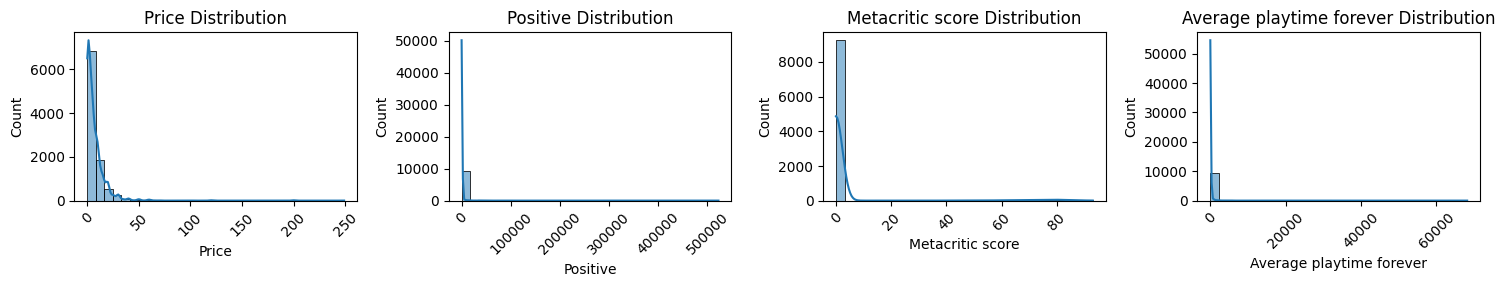

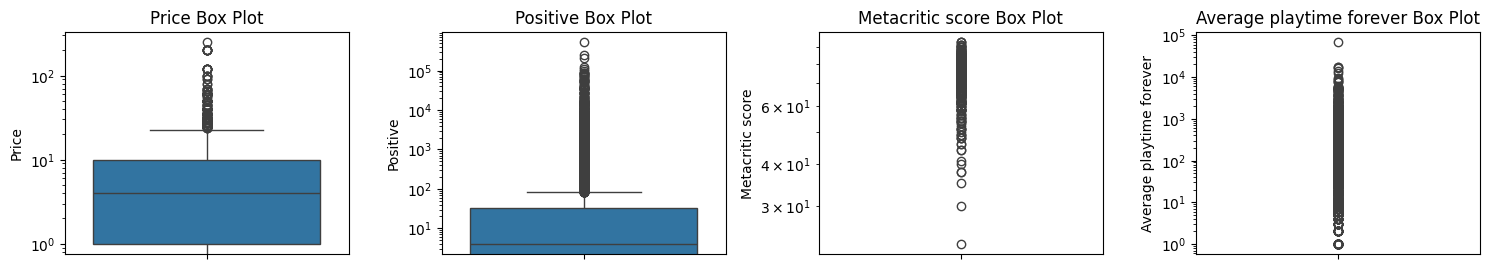

In [18]:

# Visualize distributions (histograms for numeric columns)
# Convert to Pandas for plotting (sample if needed due to size)

numeric_columns = [
    "Price", "Positive", "Metacritic score", 
    "Average playtime forever"
]

df_sample = df.select(numeric_columns).sample(fraction=0.1, seed=42).toPandas()

plt.figure(figsize=(15, 10))
for i, column in enumerate(numeric_columns, 1):
    plt.subplot(4, 4, i)
    sns.histplot(df_sample[column].dropna(), bins=30, kde=True)
    plt.title(f"{column} Distribution")
    plt.xlabel(column)
    plt.xticks(rotation=45)
    plt.ylabel("Count")
    # plt.yscale('log')
plt.tight_layout()
plt.show()

# Step 5: Box plots for outliers
plt.figure(figsize=(15, 10))
for i, column in enumerate(numeric_columns, 1):
    plt.subplot(4, 4, i)
    sns.boxplot(y=df_sample[column].dropna())
    plt.title(f"{column} Box Plot")
    plt.yscale('log')
plt.tight_layout()
plt.show()

# # Step 6: Categorical columns (e.g., Tags, Genres) - Top 10 values
# categorical_columns = ["Tags", "Genres"]
# for column in categorical_columns:
#     print(f"\nTop 10 values in {column}:")
#     df.select(explode(col(column)).alias("value")).groupBy("value").count().orderBy("count", ascending=False).show(10, truncate=False)

In [19]:
import pandas as pd
from collections import Counter

# Sample 1000 rows (adjust as needed)
df_sample = df.toPandas()

# Explode Tags
tags_list = [tag for tags in df_sample["Tags"] for tag in (tags or []) if tags]

# Count top 10
top_tags = pd.DataFrame(Counter(tags_list).most_common(30), columns=["tag", "count"])
print(top_tags)

# Save
top_tags.to_csv("top_tags.csv", index=False)

                tag  count
0             Indie  39852
1      Singleplayer  34078
2            Action  28825
3            Casual  27057
4         Adventure  26410
5                2D  17955
6          Strategy  13770
7        Simulation  13571
8               RPG  12073
9       Atmospheric  11377
10           Puzzle  11365
11               3D  10858
12     Early Access   9603
13   Pixel Graphics   9435
14         Colorful   9091
15       Story Rich   9051
16      Exploration   8384
17             Cute   8306
18     First-Person   8021
19           Arcade   7946
20      Multiplayer   7842
21          Fantasy   7691
22            Funny   6771
23          Shooter   6770
24            Retro   6511
25       Platformer   6422
26           Horror   6390
27           Sci-fi   6169
28            Anime   6143
29  Family Friendly   6053


In [20]:
import pandas as pd
from collections import Counter

# Sample 1000 rows (adjust as needed)
df_sample = df.toPandas()

# Explode Tags
genre_list = [genre for genres in df_sample["Genres"] for genre in (genres or []) if genres]

# Count top 10
top_genres = pd.DataFrame(Counter(genre_list).most_common(30), columns=["genre", "count"])
print(top_genres)

# Save
top_genres.to_csv("top_genres.csv", index=False)

                    genre  count
0                   Indie  61563
1                  Casual  36930
2                  Action  36305
3               Adventure  33450
4              Simulation  17761
5                Strategy  17018
6                     RPG  15832
7            Early Access  11643
8            Free to Play   7870
9                  Sports   4079
10                 Racing   3363
11  Massively Multiplayer   2357
12              Utilities    895
13     'price': 9.99}]}]"    644
14  Design & Illustration    519
15                Violent    495
16   Animation & Modeling    425
17              Education    392
18     'price': 4.99}]}]"    338
19           Free To Play    322
20       Video Production    308
21                   Gore    287
22       Game Development    249
23     'price': 2.99}]}]"    237
24       Audio Production    212
25      Software Training    208
26     'price': 1.99}]}]"    204
27     'price': 0.99}]}]"    199
28     'price': 5.99}]}]"    154
29     'pr

In [21]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import pandas as pd

# Load tag counts
genres_df = pd.read_csv("top_genres.csv")

# Create frequency dictionary
genres_freq = dict(zip(genres_df["genre"], genres_df["count"]))

# Generate word cloud
wordcloud = WordCloud(
    width=1024,
    height=768,
    background_color="white",  # Steam dark blue
    colormap="viridis",  # Light blue shades (#66c0f4)
    min_font_size=10,
    max_font_size=100
).generate_from_frequencies(genres_freq)

# Plot
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.savefig("genres_wordcloud.png", dpi=300, bbox_inches="tight")
plt.close()

In [22]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import pandas as pd

# Load tag counts
tags_df = pd.read_csv("top_tags.csv")

# Create frequency dictionary
tag_freq = dict(zip(tags_df["tag"], tags_df["count"]))

# Generate word cloud
wordcloud = WordCloud(
    width=1024,
    height=768,
    background_color="white",  # Steam dark blue
    colormap="viridis",  # Light blue shades (#66c0f4)
    min_font_size=10,
    max_font_size=100
).generate_from_frequencies(tag_freq)

# Plot
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.savefig("tags_wordcloud.png", dpi=300, bbox_inches="tight")
plt.close()

In [23]:
# from pyspark.sql import SparkSession
# from pyspark.sql.functions import col, log1p, year, greatest, least, lit, array_contains
# from pyspark.ml.feature import VectorAssembler
# from pyspark.ml.regression import RandomForestRegressor, LinearRegression
# from pyspark.ml.evaluation import RegressionEvaluator
# from pyspark.ml import Pipeline
# import logging

# # Configure logging
# logging.basicConfig(level=logging.INFO)
# logger = logging.getLogger(__name__)

# # Initialize Spark with increased memory and timeout
# spark = SparkSession.builder \
#     .appName("SteamML") \
#     .config("spark.driver.memory", "4g") \
#     .config("spark.executor.memory", "4g") \
#     .config("spark.network.timeout", "600s") \
#     .getOrCreate()

# # Verify data
# logger.info("Checking data schema and nulls...")
# df.printSchema()
# null_counts = {col_name: df.filter(col(col_name).isNull()).count() for col_name in df.columns}
# logger.info(f"Null counts: {null_counts}")

# # Feature engineering
# logger.info("Starting feature engineering...")
# # Cap Price at $200
# df = df.withColumn("Price_capped", greatest(lit(0), least(lit(1000), col("Price"))))

# # Convert Release date to years since 2003
# df = df.withColumn("Release_year", year(col("Release date")) - 2003)

# # Log-transform Positive (target) and Playtime for skew
# df = df.withColumn("Log_Positive", log1p(col("Positive")))
# df = df.withColumn("Log_Playtime", log1p(col("Average playtime forever")))

# # Handle Genres: One-hot encode top 5 tags
# top_tags = ["Indie", "Action", "Adventure", "RPG", "Strategy"]
# for tag in top_tags:
#     df = df.withColumn(f"Genre_{tag}", array_contains(col("Genres"), tag).cast("integer"))

# # Select features
# feature_cols = [
#     "Price_capped", "Release_year", "Achievements", "Log_Playtime",
#     "DLC count", "Metacritic score"
# ] + [f"Genre_{tag}" for tag in top_tags]

# # Prepare data: Drop nulls
# logger.info("Preparing ML data...")
# df_ml = df.select(["Log_Positive"] + feature_cols).na.drop()
# logger.info(f"ML data rows: {df_ml.count()}")

# # Split into train (80%) and test (20%)
# train_df, test_df = df_ml.randomSplit([0.8, 0.2], seed=42)
# logger.info(f"Train rows: {train_df.count()}, Test rows: {test_df.count()}")

# # Create feature vector
# assembler = VectorAssembler(inputCols=feature_cols, outputCol="features")

# # Define models with reduced complexity
# rf = RandomForestRegressor(
#     labelCol="Log_Positive",
#     featuresCol="features",
#     numTrees=50,  # Reduced from 100
#     maxDepth=5,   # Reduced from 10
#     seed=42
# )
# lr = LinearRegression(
#     labelCol="Log_Positive",
#     featuresCol="features"
# )

# # Build pipelines
# rf_pipeline = Pipeline(stages=[assembler, rf])
# lr_pipeline = Pipeline(stages=[assembler, lr])

# # Train models with error handling
# try:
#     logger.info("Training Random Forest...")
#     rf_model = rf_pipeline.fit(train_df)
#     logger.info("Training Linear Regression...")
#     lr_model = lr_pipeline.fit(train_df)

#     # Predict
#     logger.info("Making predictions...")
#     rf_predictions = rf_model.transform(test_df)
#     lr_predictions = lr_model.transform(test_df)

#     # Evaluate: RMSE, MAE, R²
#     evaluators = {
#         "rmse": RegressionEvaluator(labelCol="Log_Positive", predictionCol="prediction", metricName="rmse"),
#         "mae": RegressionEvaluator(labelCol="Log_Positive", predictionCol="prediction", metricName="mae"),
#         "r2": RegressionEvaluator(labelCol="Log_Positive", predictionCol="prediction", metricName="r2")
#     }

#     print("Model Performance:")
#     for model_name, predictions in [("Random Forest", rf_predictions), ("Linear Regression", lr_predictions)]:
#         print(f"\n{model_name}:")
#         for metric, evaluator in evaluators.items():
#             score = evaluator.evaluate(predictions)
#             print(f"{metric.upper()}: {score:.4f}")

#     # Feature importance for Random Forest
#     rf_stage = rf_model.stages[-1]
#     importances = rf_stage.featureImportances
#     feature_importance = sorted(zip(feature_cols, importances), key=lambda x: x[1], reverse=True)
#     print("\nRandom Forest Feature Importance:")
#     for feature, importance in feature_importance[:5]:
#         print(f"{feature}: {importance:.4f}")

# except Exception as e:  
#     logger.error(f"Error during training: {str(e)}")
#     raise

In [26]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, log1p, year, greatest, least, lit, array_contains
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.regression import RandomForestRegressor, LinearRegression
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml import Pipeline
import logging
import matplotlib.pyplot as plt
import pandas as pd

# Configure logging
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

# Initialize Spark
spark = SparkSession.builder \
    .appName("SteamML") \
    .config("spark.driver.memory", "4g") \
    .config("spark.executor.memory", "4g") \
    .config("spark.network.timeout", "600s") \
    .getOrCreate()

# Verify data
logger.info("Checking data schema and nulls...")
df.printSchema()
null_counts = {col_name: df.filter(col(col_name).isNull()).count() for col_name in df.columns}
logger.info(f"Null counts: {null_counts}")

# Feature engineering
logger.info("Starting feature engineering...")
# Cap Price at $200
df = df.withColumn("Price_capped", greatest(lit(0), least(lit(1000), col("Price"))))

# Convert Release date to years since 2003
df = df.withColumn("Release_year", year(col("Release date")) - 2003)

# Log-transform Positive (target), Playtime, Recommendations, Peak CCU
df = df.withColumn("Log_Positive", log1p(col("Positive")))
df = df.withColumn("Log_Playtime", log1p(col("Average playtime forever")))
df = df.withColumn("Log_Peak_CCU", log1p(col("Peak CCU")))

# Handle Genres: One-hot encode top 5 genres
top_genres = ["Indie", "Action", "Adventure", "RPG", "Strategy"]
for genre in top_genres:
    df = df.withColumn(f"Genre_{genre}", array_contains(col("Genres"), genre).cast("integer"))

# Select features
feature_cols = [
    "Price_capped", "Release_year", "Achievements", "Log_Playtime",
    "DLC count", "Metacritic score", "Log_Peak_CCU"
] + [f"Genre_{genre}" for genre in top_genres]

# Prepare data: Drop nulls
logger.info("Preparing ML data...")
df_ml = df.select(["Log_Positive"] + feature_cols).na.drop()
logger.info(f"ML data rows: {df_ml.count()}")

# Split into train (80%) and test (20%)
train_df, test_df = df_ml.randomSplit([0.8, 0.2], seed=42)
logger.info(f"Train rows: {train_df.count()}, Test rows: {test_df.count()}")

# Create feature vector
assembler = VectorAssembler(inputCols=feature_cols, outputCol="features")

# Define models
rf = RandomForestRegressor(
    labelCol="Log_Positive",
    featuresCol="features",
    numTrees=50,
    maxDepth=5,
    seed=42
)
lr = LinearRegression(
    labelCol="Log_Positive",
    featuresCol="features"
)

# Build pipelines
rf_pipeline = Pipeline(stages=[assembler, rf])
lr_pipeline = Pipeline(stages=[assembler, lr])

# Train models with error handling
try:
    logger.info("Training Random Forest...")
    rf_model = rf_pipeline.fit(train_df)
    logger.info("Training Linear Regression...")
    lr_model = lr_pipeline.fit(train_df)

    # Predict
    logger.info("Making predictions...")
    rf_predictions = rf_model.transform(test_df)
    lr_predictions = lr_model.transform(test_df)

    # Evaluate: RMSE, MAE, R²
    evaluators = {
        "rmse": RegressionEvaluator(labelCol="Log_Positive", predictionCol="prediction", metricName="rmse"),
        "mae": RegressionEvaluator(labelCol="Log_Positive", predictionCol="prediction", metricName="mae"),
        "r2": RegressionEvaluator(labelCol="Log_Positive", predictionCol="prediction", metricName="r2")
    }

    print("Model Performance:")
    for model_name, predictions in [("Random Forest", rf_predictions), ("Linear Regression", lr_predictions)]:
        print(f"\n{model_name}:")
        for metric, evaluator in evaluators.items():
            score = evaluator.evaluate(predictions)
            print(f"{metric.upper()}: {score:.4f}")

    # Feature importance for Random Forest
    rf_stage = rf_model.stages[-1]
    importances = rf_stage.featureImportances
    feature_importance = sorted(zip(feature_cols, importances), key=lambda x: x[1], reverse=True)
    print("\nRandom Forest Feature Importance (All):")
    for feature, importance in feature_importance:
        print(f"{feature}: {importance:.4f}")

    # Bar chart for non-Genre features
    non_genre_features = [
        f for f, _ in feature_importance
        if not f.startswith("Genre_")
    ]
    non_genre_importances = [
        i for f, i in feature_importance
        if not f.startswith("Genre_")
    ]

except Exception as e:
    logger.error(f"Error during training: {str(e)}")
    raise

INFO:__main__:Checking data schema and nulls...


root
 |-- AppID: string (nullable = true)
 |-- index: string (nullable = true)
 |-- Name: string (nullable = true)
 |-- Required age: double (nullable = true)
 |-- Price: double (nullable = true)
 |-- DLC count: double (nullable = true)
 |-- Detailed description: string (nullable = true)
 |-- About the game: string (nullable = true)
 |-- Short description: string (nullable = true)
 |-- Reviews: string (nullable = true)
 |-- Windows: string (nullable = true)
 |-- Mac: string (nullable = true)
 |-- Linux: string (nullable = true)
 |-- Metacritic score: double (nullable = true)
 |-- Achievements: double (nullable = true)
 |-- Recommendations: double (nullable = true)
 |-- Notes: string (nullable = true)
 |-- Supported languages: string (nullable = true)
 |-- Full audio languages: string (nullable = true)
 |-- Packages: string (nullable = true)
 |-- Developers: string (nullable = true)
 |-- Publishers: string (nullable = true)
 |-- Categories: array (nullable = true)
 |    |-- element: str

INFO:__main__:Null counts: {'AppID': 0, 'index': 0, 'Name': 6, 'Required age': 0, 'Price': 0, 'DLC count': 0, 'Detailed description': 4848, 'About the game': 4870, 'Short description': 4779, 'Reviews': 87255, 'Windows': 10, 'Mac': 6, 'Linux': 2, 'Metacritic score': 39, 'Achievements': 31, 'Recommendations': 34, 'Notes': 81901, 'Supported languages': 4837, 'Full audio languages': 56892, 'Packages': 53, 'Developers': 4913, 'Publishers': 5117, 'Categories': 0, 'Genres': 0, 'User score': 4843, 'Positive': 4033, 'Negative': 4735, 'Estimated owners': 54, 'Average playtime forever': 3949, 'Average playtime two weeks': 1194, 'Median playtime forever': 240, 'Median playtime two weeks': 3809, 'Peak CCU': 197, 'Tags': 0, 'Release date': 0, 'Price_capped': 0, 'Release_year': 0, 'Log_Positive': 4033, 'Log_Playtime': 3949, 'Log_Peak_CCU': 197, 'Genre_Indie': 0, 'Genre_Action': 0, 'Genre_Adventure': 0, 'Genre_Casual': 0, 'Genre_Simulation': 0}
INFO:__main__:Starting feature engineering...
INFO:__main

Model Performance:

Random Forest:
RMSE: 1.3171
MAE: 1.0055
R2: 0.6859

Linear Regression:
RMSE: 1.3944
MAE: 1.0638
R2: 0.6480

Random Forest Feature Importance (All):
Log_Playtime: 0.4298
Log_Peak_CCU: 0.2447
Release_year: 0.1868
Metacritic score: 0.0584
Achievements: 0.0288
Price_capped: 0.0252
DLC count: 0.0201
Genre_Indie: 0.0031
Genre_Action: 0.0026
Genre_Adventure: 0.0005
Genre_Strategy: 0.0000
Genre_RPG: 0.0000


In [28]:
# Create bar chart
plt.figure(figsize=(10, 6))
plt.bar(non_genre_features, non_genre_importances)
plt.xlabel("Features")
plt.ylabel("Importance")
plt.title("Random Forest Feature Importance (Non-Genre)")
plt.xticks(rotation=30, ha="right")
plt.tight_layout()
plt.savefig("feature_importance.png", dpi=300, bbox_inches="tight")
plt.close()

In [30]:
# Add after evaluation in your code
metrics = {
    "Random Forest": {"RMSE": 1.3171, "MAE": 1.0055, "R2": 0.6859},  # Replace with real values
    "Linear Regression": {"RMSE": 1.3944, "MAE": 1.0638, "R2": 0.6480}
}
pd.DataFrame(metrics).plot(kind="bar", color=["#66c0f4", "#a9d1f7"])
plt.xlabel("Model")
plt.xticks(rotation=35)
plt.ylabel("Metric Value")
plt.title("Model Performance Comparison")
plt.tight_layout()
plt.savefig("metrics_comparison.png", dpi=300)
plt.close()